# Data Science Coursework 1

## George Hutchings  01357062

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd
import seaborn as sns

## Task 1

Let us first import our data.

In [2]:
# Import training and test data.

# Training data.
train_data = np.genfromtxt('regression_train.csv', delimiter=',')


# Shuffle training data.
np.random.seed(190)
train_data = np.random.permutation(train_data)

orig_train_data = np.array(train_data) # Original X data
X_train = train_data[:,:-1]
y_train = train_data[:,-1]

#Test data.
test_data = np.genfromtxt('regression_test.csv', delimiter=',')
X_test = test_data[:,:-1]
y_test = test_data[:,-1]

#### Exploritory Data Analysis

I initially looked at my data set to see if there were any unusual samples, I did not find anything that I thought needed removal. We were also told on Piazza (Question 74) that our dataset is already clean, hence I concluded that I need not clean the data. It is important  to notice that the first column of the data given is ones, and so it is already an augumented matrix, also note the presence of  `orig_train_data` this will remain unchanged throughout task 1, whereas we may modify `train_data`. 

To briefly analyse the data I calculated the means and standard deviations of the test and train sets:


In [3]:
# EDA
table = np.array([np.mean(y_train), np.mean(y_test), np.var(y_train), np.var(y_test)])
table = table[None, :]
headers=["Mean of y train", "Mean of y test", "Variance of y train", "Variance of y test"]
print(tabulate(table, headers))

  Mean of y train    Mean of y test    Variance of y train    Variance of y test
-----------------  ----------------  ---------------------  --------------------
          23.0186           20.6088                89.7854               58.5304


From the above table we can see that the train set has a higher mean (~$10\%$) than the test set. As well as having a larger variance. We could therefore say that the trainng dataset has more outliers than the test set (it contains samples that are 'rare' and similar ones do not occur in the test set).

### Task 1.1.1
To consider linear regression we suppose our observed data, $(x_i, y_i), i = 1, \dots, n$ can be written as 
$$
y_i = x_i^T \beta + \varepsilon_i
$$

where $x_i \in \mathbb{R}^{p}$ are the variables (for us the rows of our $X$ matrix), $\beta \in \mathbb{R}^{p}$ are the unknown parameters and $\varepsilon_i$ is an error term.

We shall assume for all $i = 1, 2, \dots, n$, the $\varepsilon_i$ are independently identically distributed as:
$$
\varepsilon_i \sim {\mathcal {N}} \left(0,\sigma ^{2} \right)
$$
For some $ 0 < \sigma \in \mathbb{R}$

We aim to find the $\beta$ to maximise the likelihood function, that is:
$$\rm{argmax}_{\beta} \prod_{i=0}^n \mathcal {L}(\beta \mid x_i, y_i)$$
where $\mathcal {L}(\beta \mid x_i, y_i)$ is the likelihood of a single observation. We showed in lectures that that this is the least squares solution to $X\beta = y$:
$$
\beta_{ml} = \left(X^TX \right)^{-1}X^Ty
$$ 

I shall apply this to the train data in `max_lik_estimate()`, since the inputs of the training data already have a column of ones, we need not augument $X$, and intercept of the data will be accounted for in $\beta_{ml}^{(0)}$.


In [4]:
def max_lik_estimate(X, y):
    '''
    Finds the maximum likelihood estimate given inputs and outputs.

    Parameters
    ----------
    X : NxD 2D numpy array 
        Contains training inputs.
    y : Length N 1D numpy array 
        vector of training targets/observations.

    Returns
    -------
    beta_ml : Length D 1D numpy array
         Maximum likelihood parameters.

    '''
    
    beta_ml = np.linalg.solve(X.T@X, X.T@y)
    return beta_ml



# Get maximum likelihood estimate.
beta_ml = max_lik_estimate(X_train,y_train)

print('Beta_ml =', beta_ml)

Beta_ml = [ 2.25182581e+01 -6.17585676e-01  1.01692990e+03 -4.35196787e+04
  4.35195080e+04 -1.31413051e+09  9.76765983e+02 -1.64635500e-01
  1.51837665e+03 -9.73639676e+02 -4.94077967e-02 -5.14074743e+03
  7.42847683e-01 -3.71419840e+00  1.31413051e+09  5.13901319e+03
 -1.01579966e+03 -1.52187136e+03]


We can see from the above that a large number of entries of $\beta_{ml}$ are very large with $\beta_{ml}^{(5, 14)}$ are by far the largest (of magnitude), both of the order of $10^{9}$. The naive assumption from this would be to believe that the corresponding features are the 'most important' to the model, although potential colearity of predictors means this is an unwise assumption. These large magnitudes are often not desirable and can be resolved be penalising large entries of $\beta$ by using Ridge regression, we will explore this later. I will now find the in and out of sample mean squared error of the model, whch can be represented by:
$$
\hat{y} = X\beta_{ml} 
$$
to do this I will create a function, `MSE()` to calculate the mean squared error. And calculate the in sample mean squared error.

In [5]:
def MSE(y_pred, y_true):
    '''
    Computes the mean squared error.

    Parameters
    ----------
    y_pred : Length N 1D numpy array
        Estimated target values.
    y_true : Length N 1D numpy array
        Actual target values.

    Returns
    -------
    MSE : Float
        Mean squared error.

    '''
    mse = np.mean((y_true - y_pred)**2)
    return mse
    


print('In sample MSE =', MSE(X_train@beta_ml, y_train))

In sample MSE = 24.37854815595173


### Task 1.1.2
Below I use the `MSE()` function to calculate the out of sample mean squared error, I also calculate the residuals for later use.

In [6]:
print('Out of sample MSE =', MSE(X_test@beta_ml, y_test))
# For residual plot
e_ml = y_test - X_test@beta_ml

Out of sample MSE = 19.546191812082967


We can see here, that surprisingly the in sample mean squared error is larger than the out of samples. This is surprising since our model was trained on the 'in sample' data, and so we would expect that it would have a smaller out of sample MSE than out of sample MSE. 

I hypothesise that this is because we may have some features that are sparse, that is there exists some rare samples that occasionally occur inherently in the data (ie. they are not necessarily errors), these 'outliers', are more likely to be present in the training set than the test set simply due to the sizes of the sets. These outliers, due to their sparsity, have minimal effect on the $\beta$ produced by training the model, but cause a larger in sample MSE, than if they were omitted. If the training set contains none of these such outliers then its MSE (the out of sample MSE), will be lower.

The smaller out of sample MSE implies that our model generalises well, and is not overfitted.

### Task 1.2.1

I will now perform ridge regression with the data, that is to find the solution to 
$$
\rm{argmin}_{\beta} \left( \lVert y - X \beta \rVert - \lambda \lVert \beta \rVert^{2} \right)
$$
for some fixed penality parameter $0 < \lambda  \in \mathbb{R}$.

To perform ridge regression we need to standardise our input data to ensure that the penalities are applied equally. I do this below and store the mean and standard deviation of the training data for later use on the test data. I also centre the input data so that the the intercept term $\beta^{(0)}$ becomes 0 and therefore we can drop the column of ones in our $X$ data. This also means no penalty is applied to the intercept. 

This is done below, with the use of a function `standardise()` that standardises the data.

In [7]:
def standardise(X, verbose=False):
    '''
    Standardise the columns of X, optionally returning the mean and standard 
    deviation.

    Parameters
    ----------
    X : NxD 2D numpy array 
        Array to be standardised.
    verbose : bool, optional
        If True will return the mean and standard deviation of the columns of X.
        The default is False.

    Returns
    -------
    X_std : NxD 2D numpy array 
        X with its columns standardised.
    mu : N length 1D numpy array, optional (will be returned if verbose=True)
        mean of the columns of X.
    sigma : N length 1D numpy array, optional (will be returned if verbose=True)
        standard deviation of the columns of X

    '''
    mu = np.mean(X, 0)
    sigma = np.std(X, 0)
    X_std = (X - mu) / sigma
    if verbose is True:
        return X_std, mu, sigma
    else:
        return X_std


# Standardising X data (Omit the first column - ones)
train_data = train_data[:, 1:]
train_data[:, :-1], mu, sigma = standardise(train_data[:, :-1], verbose=True)
X_train = train_data[:, :-1] # Standardise
beta_0 = np.mean(y_train)
train_data[:, -1] -= beta_0 # Centring y
y_train = train_data[:, -1] 
X_test = (X_test[:, 1:]-mu) / sigma # Standardise

# Note I have not centred y_test since I would like to see if I can predict 
# the raw un-modified y_test (I will simply add mu to the prediction).

From lectures we calculated the corresponding $\beta$ to minimise the ridge loss function to be:
$$
\hat{\beta}_{ridge} = \left( X^TX + \lambda I \right)^{-1}X^Ty
$$ 
This is implemented in the below function `ridge_estimate()`.

In [8]:
def ridge_estimate(X, y, penalty):
    '''
    Calculates the maximum likelihood estimate of a ridged system with penalty
    'penalty'.

    Parameters
    ----------
    X : NxD 2D numpy array 
        Contains training inputs, note that unlike in the exercise's function
        this should already be the augmented array, that is with the first 
        column of ones.
    y : Length N 1D numpy array 
        Vector of training targets/observations.
    penalty : Float
        Penality (lambda) to be applied.

    Returns
    -------
    beta_ridge : Length D 1D numpy array
         Maximum likelihood parameters of ridged system.

    '''
    
    A = X.T @ X
    np.fill_diagonal(A, np.diag(A) + penalty)
    beta_ridge = np.linalg.solve(A, X.T @ y) 
    return beta_ridge

But which $\lambda$ should be used?

I will now perform 5 fold cross validation on the training data, to find the optimal $\lambda$. To do this I first define some functions, which create the folds (note I shuffled my data to begin with so it is not done here), and to create the train and validation sets from these folds. 

In [9]:
def cross_val_split(data, num_folds=5):
    '''
    Splits data(NxD) row wise into 'num_folds' of roughly equal size, doesnt 
    shuffle it.

    Parameters
    ----------
    data : NxD 2D numpy array
        Array to be split.
    num_folds : Integer, optional
        Number of folds to split the data into. The default is 5.

    Returns
    -------
    folds : List of length num_folds
        Each element is a numpy array, a fold.

    '''
    fold_size = len(data) // num_folds
    folds = []
    for k in range(num_folds):
        folds.append(data[k*fold_size:(k+1)*fold_size, :])
    return folds




def cross_val_train_test(folds, index):
    '''
    Given a list of folds creates validation set of folds[index] and the 
    remaining folds form the train set.

    Parameters
    ----------
    folds : list of M, Nx(D+1) numpy arrays 
        Each fold (used in cross validation).
    index : Integer less than M
        Index of the fold to be the validation set.

    Returns
    -------
    X_train : N(M-1)xD numpy array
        Set composed of the all arrays of 'folds' with the exception of folds[index] 
        stacked on top of each other with the last column removed.
    y_train : N(M-1) length 1D numpy array
        The last column as mentioned in X_train.
    X_val : NxD numpy array
        The first D columns of folds[index].
    y_val : N length 1D numpy array
        The last column as mentioned in X_val.

    '''
    i = index
    # define the training set
    train_set = np.delete(np.asarray(folds).reshape(len(folds), folds[0].shape[0], folds[0].shape[1]), i, axis=0)
    train_folds = train_set.reshape(len(train_set)*train_set[0].shape[0], train_set[0].shape[1])
    X_train = train_folds[:, :-1]  
    y_train = train_folds[:, -1]

    # define the validation set
    val_fold = folds[i] 
    X_val = val_fold[:, :-1] 
    y_val = val_fold[:, -1]
    return X_train, y_train, X_val, y_val

I then perform the cross validation on multiple linearly spaced $\lambda \in (0, 50]$, I store the validation mean squared error for each $\lambda$ and for each fold in an array, `errorv`. I also store the folds used so we can use the same folds without having to recalculate them later (they are stored in the lists `train_sets`, `test_sets`).

In [10]:
# Initialise vector of lambdas (exculuding zero since this is just normal least squares).
n = 1000 
lam = np.linspace(0, 50, n+1)[1:]

# Initialise  array to contain the MSE of the lambdas for each fold
errorv = np.empty((5,n))

folds = cross_val_split(train_data, 5)

# Storing each train and validation set for later use (without having to recalculate them)
train_sets = []
val_sets = []

# Perforing 5 fold cross validaion
for index in range(5):
    cv_X_train, cv_y_train, cv_X_val, cv_y_val = cross_val_train_test(folds, index)
    train_sets += [cv_X_train, cv_y_train]
    val_sets += [cv_X_val, cv_y_val]
    for i in range(n):
        beta_ridge = ridge_estimate(cv_X_train, cv_y_train, lam[i])
        val_score = MSE(cv_X_val@beta_ridge, cv_y_val)
        errorv[index, i] = val_score

I now find the $\hat{\lambda}_i$, that is the $\lambda$ that minimises the mean squared error for each fold against its corresponding validation set. This can be seen visually by looking at a graph and picking the lambda that corresponds to its minimum. Doing this graphically also allows you to get a general idea of what  the shape of the corresponding curve is, which we would expect to be a u shaped curve due to the bias - variance trade off.

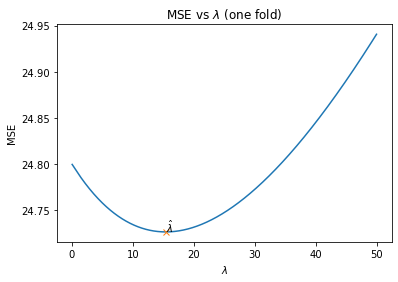

In [11]:
# Index of the lambda which minimses the MSE of each fold    
index = np.argmin(errorv, axis=1) 
lamhat = lam[index]

# Plot
i=0 # Fold to plot (let us look at the first (i=0))
plt.figure()
plt.plot(lam, errorv[i, :], markersize=2)
plt.plot(lamhat[i], errorv[i, index[i]], 'x')
plt.annotate(r"$\hat{\lambda}$", (lamhat[i], errorv[0, index[i]]))
plt.xlabel(r"$\lambda$")
plt.ylabel('MSE')
plt.title(r'MSE vs $\lambda$ (one fold)')
plt.show()

We can see that the plod indeed achieves a clear minimum (this is presented in the table below). And hence we can conclude that our cross validation has been implemented correctly. 

In [12]:
# Analyse the optimal lambda for each fold
val_mse = errorv[np.arange(5), index] # Its valdation set MSE
in_sample_mse = np.empty(5)
out_sample_mse = np.empty(5)
for i in range(5):
    beta = ridge_estimate(X_train, y_train, lamhat[i])
    in_sample_mse[i] = MSE(orig_train_data[:, 1:-1]@beta+beta_0 , orig_train_data[:, -1])
    out_sample_mse[i] = MSE(X_test@beta+beta_0, y_test)

# Table containg information on each fold 
table = np.column_stack((np.arange(1, 6), lamhat, val_mse, in_sample_mse, out_sample_mse))
headers=["Val Fold #", "Lambda hat", "Val set MSE", "In sample MSE", "Out sample MSE"]
print(tabulate(table, headers))

  Val Fold #    Lambda hat    Val set MSE    In sample MSE    Out sample MSE
------------  ------------  -------------  ---------------  ----------------
           1         15.4         24.7264          24.8499           19.2202
           2         27.45        21.909           24.9373           19.1825
           3         28.1         19.4056          24.943            19.1817
           4          2.1         29.1366          24.8054           19.3325
           5         50           37.5294          25.1678           19.198


This table shows us the various optimal lambdas, and errors for each fold, let us call the optimal lambda for fold $i$, $\hat{\lambda}_i$. We can see that there is a very high variation in the $\hat{\lambda}_{i}$ and quite often the optimal is either the smallest or largest of the $\lambda$'s tested. This is likely due to the variation of the samples which each folds provide. To alleviate this we can instead try and find the $\hat{\lambda}$ that minimises the average MSE for each fold, that is:
$$
\hat{\lambda} = \rm{argmin}_{\lambda}\frac{1}{T}\sum_{t=1}^{T}MSE_t(\lambda) = \rm{argmin}_{\lambda}<MSE(\lambda)>
$$

This will hopefully help alleviate the issue with a large variance of the $\hat{\lambda}_i$ since we are taking the mean of the mean squared error over each fold. 


### Task 1.2.2

I have calculated $\hat{\lambda}$ as well as the $\beta_{ridge}$ that corresponds to it (including $\beta_{ridge}^{(0)}$, the mean of the test data).

I have plotted the curve of $\lambda$ and $<MSE(\lambda)>$, as well as a table of the results containing its various errors.

beta ridge= [23.01856436 -0.66365986  0.51264254 -0.12557131 -0.12554188 -0.70377343
  1.65509753 -0.2145703  -1.52332419  1.65404238 -0.18189688 -0.88864627
  0.78772697 -3.17154631 -0.70377343 -0.88862171  0.51264466 -1.52338647]
  Lambda hat    CV <MSE>    In sample MSE    Out sample MSE
------------  ----------  ---------------  ----------------
        27.9     26.6408          24.9412            19.497


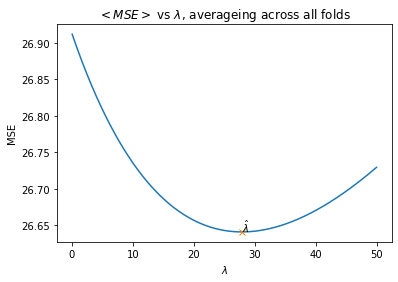

In [13]:
errorv = np.mean(errorv, axis=0) # Find the Avg MSE
index = np.argmin(errorv) # Find the position of its maximum
lamhat = lam[index] # Corresponding parameter

# Plot
plt.figure()
plt.plot(lam, errorv, markersize=2)
plt.plot(lamhat, errorv[index], 'x')
plt.annotate(r"$\hat{\lambda}$", (lamhat, errorv[index]))
plt.xlabel(r"$\lambda$")
plt.ylabel('MSE')
plt.title(r'$<MSE>$ vs $\lambda$, averageing across all folds');


beta_ridge = ridge_estimate(train_data[:, :-1], train_data[:, -1], lamhat)
beta_ridge = np.concatenate(([beta_0], beta_ridge)) # With beta_0
print('beta ridge=', beta_ridge)

in_sample_mse = MSE(orig_train_data[:, :-1]@beta_ridge, orig_train_data[:, -1])
out_sample_mse = MSE(test_data[:, :-1]@beta_ridge, test_data[:, -1])
table = np.array([lamhat, errorv[index], in_sample_mse, out_sample_mse])
headers=["Lambda hat", "CV <MSE>", "In sample MSE", "Out sample MSE"]
table = table[None, :]
print(tabulate(table, headers))

e_ridge = test_data[:, -1] - test_data[:, :-1]@beta_ridge; # storing residuals for later use

We can see that our plot does indeed produce the expected shape curve. And we obtain a $\beta_{(ridge)}$ which has coefficients that are far smaller than those of $\beta_{ml}$, again we would expect this due to the introduction of the penalty, since ridge helps reduce the issue of colinear predictors which occurs with linear regression.

Let us compare the mean squared errors between ridge and the maximum likelihood one:
+ **In sample mean squared error**, we can see that the in sample MSE for ridge is very slightly greater than that of least squares, this is what we would ideally expect. Since by construction least squares will minimise the in squared mean squared error, and ideally ridge will not deviate too far from this. 
+ **Out of sample mean squared error**, we can see that the out of sample MSE for ridge is very slightly smaller than that of least squares, this is good since the model better generalises to other data even if it is a minute improvement.

Similarly the in sample mean squared error is greater than the out of sample mean squared error. This is likely due to the same reasons as why it is so with linear regression, mentioned as above.

We should also notice that the magnitudes of the entries of $\beta_{ridge}$ have been massively reduced due to the penality, and are more evenly distributed. Whereas with $\beta_{ml}$ we had $\beta_{ml}^{(5, 14)}$ being significantly larger than any other parameters. With ridge they are of similar size, however $\beta_{ridge}^{(13)}$ is the largest leading us to believe the corresponding feature is the most important to the model, this is a more sensible assumption due to the ridge penality helping to alleviate collinearity issues.

### Task 1.3.1
The Knn algorithm begins by calculating the distance between two sets of samples $x_i, x_j$. I have implemented this in the function `euclidian_distance()` below. Which calculates the distance from a point $q$ to all rows in a given matrix ($p$).


In [14]:
def euclidian_distance(p, q):
    '''
    Computes the euclidean distancee from a each row in a matrix to a vector.
    

    Parameters
    ----------
    p : (N,D) numpy array
        Matrix to compute the distance against each of its rows.
    q : (D,) numpy vector 
        vector to compute the distance against.

    Returns
    -------
    distance : (N,) numpy array
        Array of euclidean distances from p to each row of q.

    '''

    distance = np.linalg.norm(p-q, ord=2, axis=1)
    return distance

def k_neighbours(X_test, X_train, k=5, return_distance=False):
    '''
    Returns the indicies of the k nearest neighbours of rows of X_test to rows of X_train.

    Parameters
    ----------
    X_test : (N_1,D) numpy array
    X_train : (N_2,D) numpy array
    k : integer, optional
        The number of neighbours to find. The default is 5.
    return_distance : bool, optional
        Whether or not to return the distances. The default is False.

    Returns
    -------
    neigh_ind
        indicies of the nearest neighbours. Distances are also returned if 
        return_distance is True.

    '''
    dist = []
    neigh_ind = []
  
    # compute distance from each point x_test in X_test to all points in X_train
    point_dist = [euclidian_distance(x_test, X_train) for x_test in X_test]

    # determine which k training points are closest to each test point
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]

        dist.append(dist_list)
        neigh_ind.append(ind_list)
  
    # return distances together with indices of k nearest neighbouts
    if return_distance:
        dist = np.array(dist)
        neigh_ind = np.array(neigh_ind)
        return dist, neigh_ind
    
    neigh_ind = np.array(neigh_ind)
    return neigh_ind






I then define `reg_predict()` to predict results from a train set given some test inputs, (and a k), as well as wrapper function `score()` that does this and finds the accuracy.

In [15]:
def reg_predict(X_test, X_train, y_train, k=5):
    '''
    Prededicts the outcome of X_test using X_train, y_train and the k nearest neighbours.

    Parameters
    ----------
    X_test : (N_1,D) numpy array
    X_train : (N_2,D) numpy array
    y_train : (N_2,) numpy array
    k : integer, optional
        the number of neighbours to compute against. The default is 5.

    Returns
    -------
    y_pred : (N_1,) numpy array
        predicted outcome of X_test.

    '''
    # each of the k neighbours contributes equally to the classification of any data point in X_test  
    neighbours = k_neighbours(X_test, X_train, k=k)
    # compute mean over neighbours labels (hint: use python's list comprehension)
    y_pred = np.array([np.mean(y_train[neighbour]) for neighbour in neighbours]) 

    return y_pred

def score(X_test, y_test, X_train, y_train, k=5):
    '''
    Calcualtes the mean - squared error of the prediced outputs of X_test, which 
    have been predicted using the k nearest neighbours algorithm with k 
    neighbours, and training data X_train and y_train.  

    Parameters
    ----------
    X_test : (N_1,D) numpy array
    y_train : (N_1,) numpy array
    X_train : (N_2,D) numpy array
    y_train : (N_2,) numpy array
    k : integer, optional
        the number of neighbours to compute against. The default is 5.

    Returns
    -------
    mse : float
        Mean squared error of the predicition.

    '''
    y_pred = reg_predict(X_test, X_train, y_train, k=k)
    mse = MSE(y_pred, y_test)
    return mse

I then implemented this with cross validation on the same folds as used previously. While doing this I aimed to look at the distribution of the errors. I plotted the errors on histograms for each $k$ ranging from 1 to 9, for the first fold. As well as the mean and standard deviations for each  $k$ in a table.

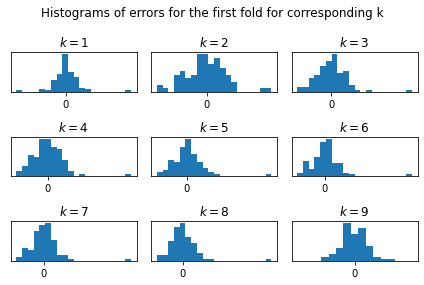

  k        mean    variance
---  ----------  ----------
  1   0.10625       18.8406
  2  -0.123125      11.4755
  3   0.0583333     15.0284
  4   0.06625       16.9614
  5   0.1395        18.6276
  6   0.137083      18.3389
  7   0.117857      17.8542
  8   0.132188      17.6818
  9   0.224722      18.3998


In [16]:
n = 9 # Number of k's to analyse.
k = np.arange(1, n+1)
errorv = np.empty((5,n))

y_train = orig_train_data[:, -1]

fold_i=0 # Fold to plot (let us look at the first (i=0))

# Initialise vectors for means and std deviations
mu = np.empty(n)
sigma = np.empty(n)
x = np.arange(-15, 15, .1)

# Initialise plot
fig, ax = plt.subplots(3, 3)
fig.suptitle("Histograms of errors for the first fold for corresponding k", fontsize=12)
row =-1



# 5 Fold cross validation (also plotting the distribution of errors from the first fold).
for index in range(5):
    twoindex = 2*index
    twoindexplusone = twoindex + 1
    # Use the folds previously used (and saved), note these have been standardised, 
    # we uncentre y to allow for direct predictions.
    cv_X_train, cv_X_val = train_sets[twoindex], val_sets[twoindex]
    cv_y_train, cv_y_val = train_sets[twoindexplusone] + beta_0, val_sets[twoindexplusone] + beta_0
    for i in range(n):
        y_pred = reg_predict(cv_X_val, cv_X_train, cv_y_train, k=k[i])
        errorv[index, i] = MSE(y_pred,  cv_y_val) # Recording MSE
        if index == fold_i: # Plot the first fold 
            col = i%3
            if col == 0:
                row += 1
            e_knn = cv_y_val - y_pred
            mu[i] = np.mean(e_knn)
            sigma[i] = np.var(e_knn)
            ax[row, col].hist(e_knn, bins = 20, label=k[i])
            ax[row, col].get_xaxis().set_ticks([0]) # Showing 0 
            ax[row, col].get_yaxis().set_ticks([])
            ax[row, col].title.set_text("$k = $%d" % k[i]) 


plt.xlim([-15, 15]) # Set x axis the same for easier comparison
plt.tight_layout()
plt.show()
                  
        
table = np.column_stack((k, mu, sigma))
headers=["k", "mean", "variance"]
print(tabulate(table, headers))

As we can see, for each $k$, the histograms look roughly bell shaped, with a centre at 0. This is what we would expect from our assumption that each error is: $ \varepsilon_i \sim {\mathcal {N}} \left(0,\sigma ^{2} \right)$.

Similarly looking at the means for each $k$ they are all approximately 0, again substantiating our above claim about the errors. Looking at the variance of the errors are approximately the same (there are slight differences but this is likely due to the difference in the folds). Hence we can see that our above assumption of the distribution of the residuals looks probable with $\sigma^2 \approx 17$.


I below, as we have done with ridge regression and $\lambda$, plot the mean squared error against the optimal $k$ for the first fold, and then show the these results in a table. 


  Val Fold #    k hat    Val set MSE    In sample MSE    Out sample MSE
------------  -------  -------------  ---------------  ----------------
           1        2       11.4907           3.35751           13.7636
           2        3       13.1393           4.87282           12.281
           3        3        9.42524          4.87282           12.281
           4        2        7.70803          3.35751           13.7636
           5        3       17.0004           4.87282           12.281


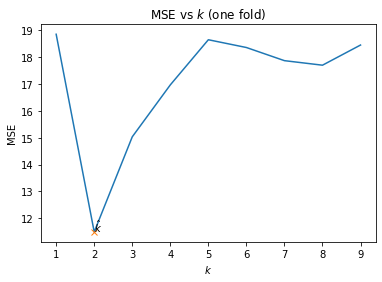

In [17]:
# Index of the k which minimses the MSE of each fold    
index = np.argmin(errorv, axis=1) 
khat = k[index]



# Plot k vs MSE for one fold (let us do first (fold_i=0))
plt.figure()
plt.plot(k, errorv[fold_i, :], markersize=2)
plt.plot(khat[fold_i], errorv[fold_i, index[fold_i]], 'x')
plt.annotate(r"$\hat{k}$", (khat[fold_i], errorv[0, index[fold_i]]))
plt.xlabel(r"$k$")
plt.ylabel('MSE')
plt.title(r'MSE vs $k$ (one fold)');


# Calculating the optimal k to minimise the average MSE (<MSE>)over the 5 folds
val_mse = errorv[np.arange(5), index]
in_sample_mse = np.empty(5)
out_sample_mse = np.empty(5)
for i in range(5):
    in_sample_mse[i] = score(orig_train_data[:,1:-1], orig_train_data[:,-1], X_train, y_train, k=khat[i])
    out_sample_mse[i] = score(X_test, y_test, X_train, y_train, k=khat[i])


# Present data of each fold in a table 
table = np.column_stack((np.arange(1, 6), khat, val_mse, in_sample_mse, out_sample_mse))
headers=["Val Fold #", "k hat", "Val set MSE", "In sample MSE", "Out sample MSE"]
print(tabulate(table, headers))

Firstly to analyse the graph, we see that, for the first fold we gain the minimum MSE at $k=2$. Analysing our table we see that the optimal $k$ is around this, either 2 or 3. And further it produces much lower MSE than with our previous methods. 

### Task 1.3.2

I will now find the $k$ that minimises the average mean squared error over all the folds, that is $\hat{k} = \rm{argmin}_{k}<MSE(k)>$. These results are presented in the table below.

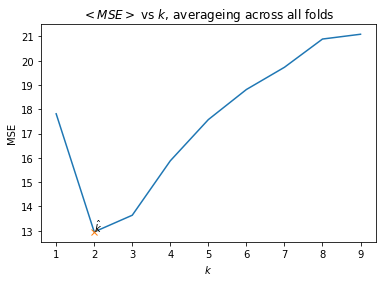

  k hat    CV <MSE>    In sample MSE    Out sample MSE
-------  ----------  ---------------  ----------------
      2     12.9523          3.97081           13.7636


In [18]:
# Avg MSE
errorv = np.mean(errorv, axis=0)
index = np.argmin(errorv) 
khat = k[index] # Optimal k  (to minimise <MSE>)

# Plot k vs <MSE>
plt.figure()
plt.plot(k, errorv, markersize=2)
plt.plot(khat, errorv[index], 'x')
plt.annotate(r"$\hat{k}$", (khat, errorv[index]))
plt.xlabel(r"$k$")
plt.ylabel('MSE')
plt.title(r'$<MSE>$ vs $k$, averageing across all folds')
plt.show()


# Presenting in table 
in_sample_mse = score(X_train, y_train, X_train, y_train, k=khat)
out_sample_mse = score(X_test, y_test, X_train, y_train, k=khat)
table = np.array([khat, errorv[index], in_sample_mse, out_sample_mse])
headers=["k hat", "CV <MSE>", "In sample MSE", "Out sample MSE"]
table = table[None, :]
print(tabulate(table, headers))

We therefore gain the overall optimal $k$, $\hat{k}= 2$. And comparing the MSE to the previous methods:
+ **In sample mean squared error**, we can see that the in sample MSE for knn is far lower than that of both ridge and linear regression methods. It is about 4 whereas previously in both ridge and linear regression it was about 24. This massive decrease implies that perhaps linear methods are not wise to to model our data.

+ **Out of sample mean squared error**, we can see that the out of sample MSE for knn is lower than that of both ridge and linear regression methods. It is about 14 whereas previously in both ridge and linear regression it was about 19. This massive decrease again implies that perhaps linear methods are not wise to to model our data.

The presence of in sample outliers may be the cause of the large difference of of these errors.

It can therefore be safely claimed that our data cannot be lineary modeled (well) , that it is non-linear, and a non linear model, like knn would be more optimal.

Also from , with regards to the homogeneity of the data, perhaps the test and train data are not from the same distribution. The knn MSE for in and out of sample is quite different supporting this, also at the start of this task we saw the mean of the train and test data outputs were quite dfferent.


To consolodate I will consider the errors across all methods using a residual plot as below.


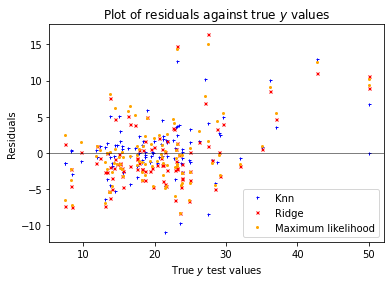

In [19]:
y_pred = reg_predict(X_test, X_train, y_train, k=khat)
e_knn = y_test - y_pred

# Plot resduals for prior methods
plt.figure()
plt.plot(y_test, e_knn, '+', markersize=3, color ='blue', label='Knn')
plt.plot(y_test, e_ridge, 'x', markersize=3, color ='red', label='Ridge')
plt.plot(y_test, e_ml, 'o', markersize=2, color ='orange', label='Maximum likelihood')
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel("True $y$ test values")
plt.ylabel('Residuals')
plt.title('Plot of residuals against true $y$ values')
plt.legend()
plt.show()

We can see that the errors across all methods look similar the same, however it seems that the errors for knn are less, particuarly at high $y$ values (ie. it perhaps models the more extreme results better).

## Task 2

### Task 2.1.1

Logistic regression, despite its name, is a linear model for classification rather than regression. In its original form, it is used for binary classifications, i.e., assigning a data point in our test set a binary label.


In [20]:
# Import training and test data
train_data = np.genfromtxt('classification_train.csv', delimiter=',')
test_data = np.genfromtxt('classification_test.csv', delimiter=',')
X_train = train_data[:,:-1].T # Transpose for use with logistic regression
y_train = train_data[:,-1]
X_test = test_data[:,:-1].T # Transpose for use with logistic regression
y_test = test_data[:,-1]
y_train = y_train.astype(int)
y_test = y_test.astype(int)

We define a function `logistic()` which impliments the below function that is used in logistic regression.
$$
f(x) = \frac{1}{1+e^{-x}}
$$

In [21]:
def logistic(x):
    '''
    Logistic function, computes 1 / (1 + np.exp(-x))
    

    Parameters
    ----------
    x : (N,) numpy array

    Returns
    -------
    logit : (N,) numpy array
        1 / (1 + np.exp(-x)).

    '''
    logit = 1 / (1 + np.exp(-x))
    return logit  


We analogous to the coding tasks we next define 
$$
\hat{\boldsymbol y}_{\text{log}} = f(\boldsymbol \beta^T \boldsymbol X + \beta_0)
$$

for use in logistic regression, this is done below.

In [22]:
def predict_log(X, beta, beta_0):
    '''
    Calculates y_log as per the lecture notes

    Parameters
    ----------
    X: data of size (d, n)
    beta: parameters, a numpy array of size (d, 1)
    beta_0: offset, a scalar

    Returns
    -------
    y_log : (1, n) numpy array
        y_log as decriibed in lecure notes.

    '''
    y_log = logistic(beta.T @ X + beta_0) 
    return y_log

We then define functions to help us calculate the the gradients of the loss function, that is: 
$$
\frac{\partial \mathcal L}{\partial \boldsymbol \beta} = \frac{1}{n} \sum_{i=1}^n ( y^{(i)} - \hat{y}_{\text{log}}^{(i)}) X^{(i)}
$$
$$
\frac{\partial \mathcal L}{\partial \beta_0} = \frac{1}{n} \sum_{i=1}^n ( y^{(i)} - \hat{y}_{\text{log}}^{(i)})
$$

Where we have the loss function $
\mathcal L = - \frac{1}{n} \sum_{i=1}^n y^{(i)} \log(\hat{y}_{\text{log}}^{(i)}) + (1-y^{(i)}) \log (1-\hat{y}_{\text{log}}^{(i)}) \,
$ that we are aiming to minimise. we initilise our $\beta$, $\beta_0$ with 0's.

In [23]:
def initialise(d):
  """    
  Argument:
  d: size of the beta vector (or number of parameters)
  
  Returns:
  beta: initialised vector of shape (d, 1)
  beta_0: initialised scalar (corresponds to the offset)
  """
  
  beta = np.zeros(shape=(d, 1), dtype=np.float32)
  beta_0 = 0
  
  assert(beta.shape==(d, 1))
  assert(isinstance(beta_0, float) or isinstance(beta_0, int))
  
  return beta, beta_0



def propagate(X, y, beta, beta_0, threshold=0.5):
  """
  Arguments:
  X: data of size (d, n)
  y: true label vector of size (1, n)
  beta: parameters, a numpy array of size (d, 1)
  beta_0: offset, a scalar

  Returns:
  cost: negative log-likelihood cost for logistic regression
  dbeta: gradient of the loss with respect to beta
  dbeta_0: gradient of the loss with respect to beta_0
  """
  n = X.shape[1]
  y_log = predict_log(X, beta, beta_0)

  # cost function
  cost = (-1) * np.mean(np.multiply(y, np.log(y_log)) + np.multiply(1-y, np.log(1 - y_log)), axis=1)

  # derivatives
  dbeta = (1/n) * X @ np.transpose(y_log - y)
  dbeta_0 =  np.mean((y_log - y))

  assert(dbeta.shape==beta.shape)
  assert(dbeta_0.dtype==float)
  cost = np.squeeze(cost)
  assert(cost.shape==())
  
  # store gradients in a dictionary
  grads = {"dbeta": dbeta, "dbeta_0": dbeta_0}
  
  return grads, cost

We combine the above functions, to form one function `optimise()`, which calculates the gradients using `propagate()` then moves in this direction by a size equal to the learning rate, it does this repeatedly for a set number of iterations.

In [24]:
def optimise(X, y, beta, beta_0, num_iterations=1000, learning_rate=0.005, print_cost=False):
  """
  Arguments:
  X: data of size (d, n)
  y: true label vector of size (1, n)
  beta: parameters, a numpy array of size (d, 1)
  beta_0: offset, a scalar
  num_iterations: number of iterations gradient descent shall update the parameters
  learning_rate: step size in updating procedure
  print_cost: whether to print the cost every 100 iterations or not

  Returns:
  params: dictionary containing the parameters beta and offset beta_0
  grads: dictionary containing the gradients
  costs: list of all the costs computed during the optimisation (can be used to plot the learning curve).
  """
  costs = []
    
  for i in range(num_iterations):

      # calculate cost and gradients
      grads, cost = propagate(X, y, beta, beta_0)
      
      # retrieve derivatives from grads
      dbeta = grads["dbeta"]
      dbeta_0 = grads["dbeta_0"]
      
      # updating procedure
      beta = beta - learning_rate * dbeta 
      beta_0 = beta_0 - learning_rate * dbeta_0 
      
      # record the costs (incase i would like to plot this)
      if i % 100 == 0:
          costs.append(cost)
  
  # save parameters and gradients in dictionary
  grads = {"dbeta": dbeta, "dbeta_0": dbeta_0}
  
  return beta, beta_0, grads, costs

To make cross validation easier I create a function `log_r_betas()` that returns the optimised $\beta$, $\beta_0$ given training data, the number of iterations and the learning rate. I do this since the $\beta$'s are independent of the given threshold and so they can be calculated and then reused for different thresholds (assuming everything else remains the same).

In [25]:
def log_r_betas(X_train, y_train, num_iterations=5000, learning_rate=0.5):
    '''
    Calculates beta, beta_0 for a given X_traiin, y_train, number of iterations
    and learing rate.
    

    Parameters
    ----------
    X_train: data of size (d, n)
    y_train: true label vector of size (1, n)
    num_iterations: number of iterations gradient descent shall update the parameters
    learning_rate: step size in updating procedure

    Returns
    -------
    beta: parameters, a numpy array of size (d, 1)
    beta_0: offset, a scalar

    '''
    
    beta, beta_0 = initialise(X_train.shape[0])
    # gradient descent
    beta, beta_0, _, _ = optimise(X_train, y_train, beta, beta_0, num_iterations, learning_rate)

    return beta, beta_0

I then create a a function to predict the outcome given the gradients of $\beta$ ,$\beta_0$ the threshold (and some test variables), to help with cross validation.

In [26]:
def predict(X_test, beta, beta_0, threshold=0.5):
  """
  Arguments:
  X_test: test data of size (d, n)
  beta: parameters, a numpy array of size (d, 1)
  beta_0: offset, a scalar

  Returns:
  y_pred: vector containing all binary predictions (0/1) for the examples in X_test
  """
  n = X_test.shape[1]
  y_pred = np.zeros((1,n))
  beta = beta.reshape(X_test.shape[0], 1)
  
  # compute vector y_log predicting the probabilities
  y_log = predict_log(X_test, beta, beta_0)
  
  for i in range(y_log.shape[1]):
      
      # convert probabilities y_log to actual predictions y_pred
      if y_log[0, i] > threshold:
          y_pred[0, i] = 1
      else:
          y_pred[0, i] = 0
  
  assert(y_pred.shape==(1, n))
  
  return y_pred

I now perform cross validation to optimise the learning rate and threshold. The grid I will search will contain: 
$$ \text{Threshold} \in [0.44, 0.52]$$
$$ \text{Learning rate} \in (0, 0.15]$$

I chose this region since when exploring other regions the accuracy was far lower, and including these regions provided no improvement to parameters and increased the computation time massively. 

The results of the optimal pair of parameters found for each fold is given below.

In [27]:
# Initialise hyperparameters
nlr = 5
nth = 50
n  = nlr*nth
lrs = np.linspace(0, 0.15, nlr+1)[1:]
ths = np.linspace(0.44, 0.52, nth)
params = np.array(np.meshgrid(lrs, ths)).T.reshape(-1,2)

# Initialise  array to contain the MSE of the hyperparameters for each fold
acc = np.empty((5,n))
folds = cross_val_split(train_data, 5)


# Save training and validation sets for later use (NON-TRANSPOSED X is saved)
train_sets = []
val_sets = []

# 5 fold cross validation grid 
for index in range(5):
    cv_X_train, cv_y_train, cv_X_val, cv_y_val = cross_val_train_test(folds, index)
    cv_y_train, cv_y_val = cv_y_train.astype(int), cv_y_val.astype(int)
    train_sets += [cv_X_train, cv_y_train]
    val_sets += [cv_X_val, cv_y_val]
    cv_X_train, cv_X_val = cv_X_train.T, cv_X_val.T
    
    for i in range(nlr):
        beta, beta_0 = log_r_betas(X_train, y_train, num_iterations=5000, learning_rate=lrs[i])
        index1 = i*nth
        for j in range(nth):
            y_pred_val = predict(cv_X_val, beta, beta_0, threshold=ths[j])
            val_score = np.mean(np.abs(y_pred_val - cv_y_val))
            acc[index, index1 +j] = val_score    
acc = 100 * (1-acc)
    
# Index of the parameters which minimses the MSE of each fold  
index = np.argmax(acc, axis=1) 
paramshat = params[index, :]

i=0 # Fold to plot (let us look at the first (i=0))
val_acc = acc[np.arange(5), index]
in_acc = np.empty(5)
out_acc = np.empty(5)
for i in range(5):
    beta, beta_0 = log_r_betas(X_train, y_train, num_iterations=5000, learning_rate=paramshat[i,0])
    # predict test and train set examples
    y_pred = predict(X_train, beta, beta_0, threshold=paramshat[i,1])
    out_acc[i] = np.mean(np.abs(y_pred - y_train))
    y_pred = predict(X_test, beta, beta_0, threshold=paramshat[i,1])
    in_acc[i] = np.mean(np.abs(y_pred - y_test))
out_acc = 100*(1-out_acc)
in_acc = 100*(1-in_acc)

# Present data
table = np.column_stack((np.arange(1, 6), np.round(paramshat[:,0], 3), np.round(paramshat[:,1], 2), val_acc, in_acc, out_acc))
headers=["Val Fold #", "LR hat", "Thresh hat", "Val set acc", "In sample acc", "Out sample acc"]
print(tabulate(table, headers))

  Val Fold #    LR hat    Thresh hat    Val set acc    In sample acc    Out sample acc
------------  --------  ------------  -------------  ---------------  ----------------
           1      0.03          0.45         74.375             74              74
           2      0.03          0.52         75                 73              74.375
           3      0.12          0.48         81.875             73.5            74.875
           4      0.15          0.47         71.875             73.5            74.75
           5      0.03          0.51         76.25              73              74.5


As we can see the accuracy seems high, performing  quite well, both in and out of sample, achieving well over 70. However let us notice that the train and test set outcomes have a majority of ones, the proportion is shown in the table below

In [28]:
table = [[np.mean(y_train), np.mean(y_test)]]
headers = headers=["Proportion of 1's in y train", "Proportion of 1's in y test"]
print(tabulate(table, headers))

  Proportion of 1's in y train    Proportion of 1's in y test
------------------------------  -----------------------------
                       0.70375                          0.685


And therefore naively picking 1 as an outcome irrespective of the inputs would result in a in and out of sample accuracies that are $70\%$ and $69\%$, respectively. This should perhaps be considered when looking at the accuracies.

### Task 2.1.2

Similarly to what we have done when using cross validation as before, I now aim to calculate the parameters that minimise the average MSE across all folds, that is:
$$
(\hat{T}, \hat{LR}) = \rm{argmin}_{(T,LR)} \left( \frac{1}{5}\sum_{i=1}^{5}\text{accuracy}_i\left( T,LR \right)\right)= \rm{argmin}_{(T,LR)} <\text{accuracy}\left( T,LR \right)>
$$

Using similar notation to before, where $T$ and $LR$ refer to the learning rate and  the threshold, and $< \text{accuracy}>$ refers to the mean of the accuracies of each fold. I do this by averaging the accuracy across the folds and then picking the index referring to the maximum, I plot this in the graph below.

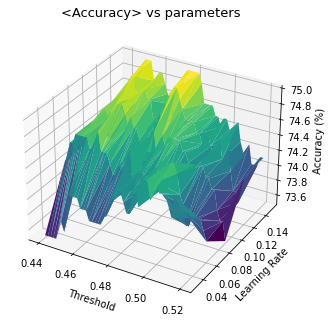

In [29]:
# Avg mse
acc = np.mean(acc, axis=0)
# Plot of hyperparameters against accuracy 
y = params[:,0]
x = params[:,1]
z = acc
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(x, y, z, cmap=cm.viridis)
ax.set_ylabel("Learning Rate")
ax.set_xlabel("Threshold")
ax.set_zlabel("Accuracy (%)")
ax.set_title("<Accuracy> vs parameters", fontsize=13)
ax.get_xaxis().set_ticks(np.arange(0.44, 0.52, 0.02)) # Aesthetics
plt. show()

We can see there are a couple peaks of this graph, at a larger learning rate (relative to its axis scale), and at a couple of central thresholds. I now calculate this peak more rigorously:

In [30]:
# Find hyperparameters that maximise average accuracy 
index = np.argmax(acc) 
paramshat = params[index, :]

beta, beta_0 = log_r_betas(X_train, y_train, num_iterations=5000, learning_rate=paramshat[0])
y_pred = predict(X_train, beta, beta_0, threshold=paramshat[1])
out_acc = 100 - 100*np.mean(np.abs(y_pred - y_train))
y_pred = predict(X_test, beta, beta_0, threshold=paramshat[1])
in_acc = 100 - 100*np.mean(np.abs(y_pred - y_test))


# Display as table
table = np.array([paramshat[0], paramshat[1], acc[index], in_acc, out_acc])
headers=["LR hat", "T hat", "CV <acc>", "In sample acc", "Out sample acc"]
table = table[None, :]
print(tabulate(table, headers))


  LR hat     T hat    CV <acc>    In sample acc    Out sample acc
--------  --------  ----------  ---------------  ----------------
    0.12  0.454694          75             72.5                75


And hence I find:
$$
\hat{LR} = 0.12
$$
$$
\hat{T} = 0.454694
$$

We can also consider the confusion matrix of this model as below:

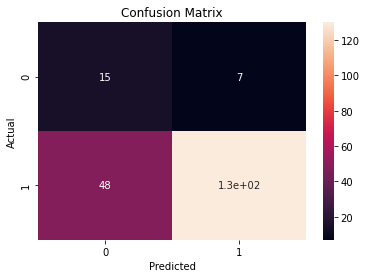

In [31]:
def confusion_mat(y_actu, y_pred, plot=True):
    '''
    Computes the Confusion matrix and various accuracies.

    Parameters
    ----------
    y_actu : (N,)
        Actual Outputs.
    y_pred : (N,)
        preducted outputs.
    plot : bool, optional
        Whether a plot to be printed or not. The default is True.

    Returns
    -------
    acc : float
        Accuracy.
    spec : float
        Specificity.
    precis : float
        Precision.
    rec : float
        Recall.
    F1 : float
        F1 score.

    '''
    y_actu, y_pred = list(y_actu), list(y_pred)
    FP = 0
    TN = 0
    TP = 0
    FN = 0
    l = len(y_actu)
    for i in range(l):
        if y_actu[i] == 0:
            if y_pred[i] == 1:
                FP += 1
            else:
                TN += 1
        if y_actu[i] == 1:
            if y_pred[i] == 1:
                TP += 1
            else:
                FN += 1
                
    acc = (TP+TN) / l
    precis = TP / (TP+FP)
    rec = TP / (TP+FN)
    spec = TN / (TN+FP)
    F1 = 2 * precis * rec / (precis+rec)
    if plot:
        conf_mat = np.array([[TN,FN], [FP, TP]])
        sns.heatmap(conf_mat, annot=True)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted') 
        plt.ylabel('Actual')
        plt.show()
    return acc, spec, precis, rec, F1

confusion_mat(y_test, y_pred[0, :]);

We can see that despite our model being quite accurate it has a tendency to predict a few false positives (rather than false negatives). This is likely due to the fact, as mentioned previously our data has a large proportion of ones.

### Task 2.2.1

To do random forests I implement the code from the coding task with some changes, some of these changes were suggested in the Piazza post Question \#56.

Ignore for a moment the idea of forests, and let us first consider forming a single tree to model our data. The modelling in the coding task was done with the assumption of discrete variables and so it did not split the data into two regions $\{x : x< s\}$ and $\{x : x \geq s\}$. I have amended the function to split into these two regions, so called the left region and the right region. Further in the coding task a variable was removed once it had been split from, this is sub-optimal for our data since we may want to split the same feature more than once, this has been done in the function `split_dataset()` and then `choose_best_feature()` has been amended to accommodate for these changes.

I have changed the coding task's Gini-impurity to instead calculate the cross entropy (this is done in function `cr_ent()`) that is:
$$
CE(\pi) = \sum_i\pi_i log(1-\pi_i)
$$
Although in some cases we have $\pi_i = 1$ and hence we attempt to calculate $log(0)$ to resolve this I have added a small amount inside the log and use this definition instead:
$$
CE(\pi) \approx \sum_i\pi_i log(1-\pi_i+10^{-10})
$$

In [32]:
def cr_ent(y, sample_weights=None):
  """ 
  Calculate the Cross Entropy for labels.
  Arguments:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (float): the gini impurity for y.
  """
  if sample_weights is None:
      sample_weights = np.ones(y.shape[0]) / y.shape[0]
  
  cross = 0
  num = y.shape[0]  # number of labels
  label_counts = {}  # caculate different labels in y，and store in label_counts
  for i in range(num):
      if y[i] not in label_counts.keys():
          label_counts[y[i]] = 0
      label_counts[y[i]] += sample_weights[i]
  
  for key in label_counts:
      prob = float(label_counts[key]) / float(np.sum(sample_weights))
      cross += prob * np.log(1-prob+10**-10)

  return cross


def split_dataset(X, y, column, value, sample_weights=None):
  """
  Return the split of data whose column-th feature equals value.
  Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      column: the column of the feature for splitting.
      value: the value of the column-th feature for splitting.
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (np.array): the subset of X whose column-th feature equals value.
      (np.array): the subset of y whose column-th feature equals value.
      (np.array): the subset of sample weights whose column-th feature equals value.
   """ 

  left_i = []
  right_i = []
  featVec = X[:, column]
  # Seperate data into two regions, < value, >= value
  for i in range(len(featVec)):
      if featVec[i] <= value:
          left_i.append(i)
      else:
          right_i.append(i)     
  Xl = X[left_i,:]
  yl = y[left_i]
  Xr = X[right_i,:]
  yr = y[right_i]
  # returns list of splits
  if (sample_weights is None):
      return [(Xl, yl), (Xr, yr)]
  else:
      return [(Xl, yl, sample_weights[left_i]) , (Xr, yr, sample_weights[right_i])]





def cr_ent_2(X, y, column, value, sample_weights=None):
  """
  Calculate the resulted Cross Entropy given a vector of features.
  Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      column: the column of the feature for calculating. 0 <= column < D
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (float): the resulted gini impurity after splitting by this feature.
  """
  if sample_weights is None:
      sample_weights = np.ones(y.shape[0]) / y.shape[0]
  
  new_impurity = 0
  old_cost = cr_ent(y, sample_weights)
  
  new_cost = 0.0
  #split the values of i-th feature and calculate the cost
  for sub_X, sub_y, sub_sample_weights in split_dataset(X, y, column, value, sample_weights):
      prob = np.sum(sub_sample_weights) / float(np.sum(sample_weights))
      new_cost += prob * cr_ent(sub_y, sub_sample_weights)
      
  
  new_impurity = old_cost - new_cost # information gain

  return new_impurity




def choose_best_feature(X, y, n_features=None, sample_weights=None):
  """
  Choose the best feature to split according to criterion.
  Args:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      n_features: number of predictors to use. Defaults to maximum.
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (int): the column for the best feature
  """
  n_cols = X.shape[1]   
  if sample_weights is None:
      sample_weights = np.ones(y.shape[0]) / y.shape[0]
  if n_features is None:
      n_features = n_cols   
  best_gain_cost = 0.0
  best_feature_idx = None
  best_feature_val = None
  features = np.random.choice(np.arange(n_cols), size=n_features, replace=False)
  for i in features:
      unique_vals = np.unique(X[:, i])
      for value in unique_vals:
          info_gain_cost = cr_ent_2(X, y, i, value, sample_weights)
          if info_gain_cost > best_gain_cost:
              best_gain_cost = info_gain_cost
              best_feature_idx = i
              best_feature_val = value         
  return best_feature_idx, best_feature_val 


This gives us a basis for building a tree, however when building a forest we need to know the exact probabilities of being in each class (0 or 1 for us), as opposed to the class that is the most likely to allow us to make a prediction from the forest.

That is, for an input, and the corresponding probability vector for each tree in the forest, $\pi^{DT}$ we aggregate the probabilities to calculate the most likely output.
$$
\pi = \frac{1}{B}\sum_{b=1}^{B}\pi^{DT}_{b}
$$

To help impliment this I created a function `prob_of_one()` that effectively replaces the majority vote function used in the notebooks. This function will calculate the proportion of labels that are one, given a vector of training labels. Therefore our trees now store the probability of that region containing a one as opposed to the most likely label.

Working with probabilities would disrupt our classify function and so I created a new function `classify_forest()` that inputs a single sample and classifies it, that is it takes the probability found by classifying the sample and converts it into a 1 or 0 (with default threshold of 0.5). This combined with the `predict()` function which has been slightly modified to allow for forest inputs, allows us to predict from forests.

In [33]:
def prob_of_one(y, sample_weights=None):
  """
  Return the proportion of labels which appear in y that are ones (as opposed to zeros).
  Args:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (int): the majority label
  """
  l = len(y)
  if sample_weights is None:
      sample_weights = np.ones(l) / l
  
  proba_one = np.sum(y*sample_weights)/ np.sum(sample_weights)
  return proba_one



def build_tree(X, y, feature_names, depth, n_features, max_depth=10, sample_weights=None, min_samples_leaf=2):
  """Build the decision tree according to the data.
  Args:
      X: (np.array) training features, of shape (N, D).
      y: (np.array) vector of training labels, of shape (N,).
      feature_names (list): record the name of features in X in the original dataset.
      depth (int): current depth for this node.
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (dict): a dict denoting the decision tree. 
      <tree> ::= node:'leaf' label:<iris-categ>
              |  node:'split' feature-name:<col-name> value:<num> leaf:<tree> right:<tree>  
  """
  mytree = dict()

  # include a clause for the cases where (i) no feature, (ii) all lables are the same, 
  # (iii) depth exceed, or (iv) X is too small
  if len(feature_names)==0 or len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf: 
    mytree = { 'node':'leaf' ,  'label': prob_of_one(y, sample_weights) }
  else:  
    best_feature_idx, value = choose_best_feature(X, y, n_features, sample_weights)
    if best_feature_idx is None:
        mytree = { 'node':'leaf' ,  'label': prob_of_one(y, sample_weights) }
    else:
        best_feature_name = feature_names[best_feature_idx]
        feature_names = feature_names[:]
        splits = split_dataset(X, y, best_feature_idx, value, sample_weights)
        mytree = { 'node':'split', 'feature_name':best_feature_name, 'value':value }
        mytree['left'] = build_tree(splits[0][0], splits[0][1], feature_names, depth+1, n_features, max_depth, splits[0][2],) 
        mytree['right'] = build_tree(splits[1][0], splits[1][1], feature_names, depth+1,n_features, max_depth, splits[1][2])

  return mytree

def train(X, y, n_features, max_depth=10, sample_weights=None):
  """
  Build the decision tree according to the training data.
  Args:
      X: (pd.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
      y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] <= C. Here C = 1.
      sample_weights: weights for each samples, of shape (N,).
  """
  if sample_weights is None:
      # if the sample weights is not provided, we assume the samples have uniform weights
      sample_weights = np.ones(X.shape[0]) / X.shape[0]
  else:
      sample_weights = np.array(sample_weights) / np.sum(sample_weights)

  feature_names = X.columns.tolist()
  X = np.array(X)
  y = np.array(y)
  tree = build_tree(X, y, feature_names, 1, n_features, max_depth, sample_weights=sample_weights)
  return tree


def classify(x, tree):
  """
  Classify a single sample with the fitted decision tree.
  Args:
      x: (pd.Dataframe) a single sample features, of shape (D,).
  Returns:
      (int): predicted testing sample label.
  """
  if tree['node'] == 'leaf':
    return tree['label']
  else:
    feature_name = tree['feature_name']
    v = x.loc[feature_name]
    if (v <= tree['value']):
        return classify(x, tree['left'],)
    else:
        return classify(x, tree['right'])

def classify_forest(x, forest, threshold=0.5):
    '''
    Classifies a single sample with a forest.

    Parameters
    ----------
    x : x: (pd.Dataframe) a single sample features, of shape (D,).
        Feature to be classified.
    forest : list of trees
        list of trees.
    threshold : float (between 0 and 1), optional
        The threshold at which we catorgise 1 or 0. The default is 0.5.

    Returns
    -------
    outcome : Integer 1 or 0
        1 if the mean probability of x being a 1 is >= threshold.

    '''
    proba_one = []
    for tree in forest:
        # Find the probability of x being a one for each tree
        proba_one.append(classify(x, tree))
    proba_one = np.mean(proba_one)
    if proba_one < threshold:
        outcome = 0
    else:
        outcome = 1
    return outcome
    

def predict(X, forest):
  """
  Predict classification results for X from a forest.
  Args:
      X: (pd.Dataframe) testing sample features, of shape (N, D).
      forest: list of trees.
  Returns:
      (np.array): predicted testing sample labels, of shape (N,).
  """
  if len(X.shape)==1:
      return classify_forest(X, forest)
  else:
      results=[]
      for i in range(X.shape[0]):
          results.append(classify_forest(X.iloc[i, :], forest))
      return np.array(results)

To impliment the subsampling I create a function `subsample()`, seen below and then to collate all these functions `bagging_train_forest()` which creates a forest using feature bagging.

In [34]:
# Create a random subsample from the dataset with replacement
def subsample(X, y, n=None, rand=None):
    '''
    Creates subsample of X, y with replacement of size n with random seed 'rand'.

    Parameters
    ----------
    X : pd.Dataframe (N,D)
        Variables to be sampled.
    y : pd.series (N,)
        Target to be sampled.
    n : integer, optional
        Size of random samples. The default is None.
    rand : integer, optional
        The seed to be used. The default is None.

    Returns
    -------
    Xsamp : pd.Dataframe (n,D)
        Subsample of X.
    ysamp : pd.series (n,)
        Subsample of y.

    '''
    if n is None:
        n = len(y)
    if rand is None:
        rand = np.random.randint(99999999)
    Xsamp = X.sample(n, replace=True, random_state=rand)
    ysamp = y.sample(n, replace=True, random_state=rand)
    return Xsamp, ysamp 


def bagging_train_forest(X_train, y_train, n_features, max_depth, B):
    '''
    Creates a forest of B trees, considering a maximum of n_features per tree, 
    each with a maximum depth of max_depth. 
    

    Parameters
    ----------
    X_train : (pd.Dataframe) testing sample features, of shape (N, D).
        Features to train from.
    y_train : (pd.Dataframe) testing sample features, of shape (N,).
        Outputs to train from.
    n_features : Integer
        Maximum number of features.
    max_depth : Integer
        Maximum depth of each tree.
    B : Integer
        number of trees of in forest.

    Returns
    -------
    forest : List of trees (length B)

    '''
    forest = list()
    for i in range(B):
        X, y = subsample(X_train, y_train)
        tree = train(X, y, n_features, max_depth)
        forest.append(tree)
    return forest


def scoredt(y_pred, y_actu):
    '''
    Produces the accuracy of the prediction, against the actual values.

    Parameters
    ----------
    y_pred : (N,) Vector of predicted values.
        Predicted values.
    y_actu : (N,) Vector of actual values.
        actual values.

    Returns
    -------
    Acc : float
    Accuracy of prediction. That is (True positives + True Negatives) / Total predictions
        

    '''
    acc = np.float(sum(y_pred==y_actu)) / float(len(y_actu))
    return acc

I now perform a grid search on a set of hyper parameters, the Maximum depth (`mds`), Number of trees (`Bs`), and the maximum number of features  (`ps`). I only tried a small sample of hyper-parameters since otherwise the computational time is enormous. In lecture notes we were told the optimal $p$ is often $\frac{p}{4}$ for classifciation problems, and hence I included this in the parameters I tested. Ideally we would analyse far more hyperparamters and then see if the if they provided a feasible increase. That is is the computation of increasing, say the number of trees (or their depth), provides a better model and is worth the additional computation - does it provide a large accuracy increase.

I outputted my results in the table below:

In [35]:
# Hyper parametters to grid search through 
mds = [5, 6]
Bs = [3, 4]
ps = [3, 4]

nmds = len(mds)
nBs = len(Bs)
nps = len(ps)
n  = nBs*nps*nmds
acc = np.empty((5,n))

# Array of all possible combinations of hyper-parameters
params = np.array(np.meshgrid(mds, Bs, ps)).T.reshape(-1,3) 

# Cross validation gridsearch of hyperparameters. NOTE we need to convert our 
# data to dataframes for use with our function. (and transpose it to undo the 
# trasposition done for logistic regression). We use the same folds for comparison.
for index in range(5):
    print('Computing fold', index+1 )
    twoindex = 2*index
    twoindexplusone = twoindex + 1
    cv_X_train, cv_X_val = train_sets[twoindex], val_sets[twoindex]
    cv_y_train, cv_y_val = train_sets[twoindexplusone], val_sets[twoindexplusone]
    cv_X_train = pd.DataFrame(cv_X_train)
    cv_X_val = pd.DataFrame(cv_X_val)
    cv_y_train = pd.DataFrame(cv_y_train)
    cv_y_val = pd.DataFrame(cv_y_val)
    cv_y_train = cv_y_train.T.squeeze()
    cv_y_val = cv_y_val.T.squeeze()
    for i in range(n):
        max_depth = params[i, 0]
        B = params[i, 1]
        n_features = params[i, 2]
        forest = bagging_train_forest(cv_X_train, cv_y_train, n_features, max_depth, B)
        y_pred = predict(cv_X_val, forest)
        val_acc = scoredt(y_pred, cv_y_val)
        acc[index, i] = val_acc
        

# Find the optial parameters for each fold
index = np.argmax(acc, axis=1) 
paramshat = params[index, :]

# Convert data to data frames
X_train = pd.DataFrame(X_train.T)
y_train = pd.DataFrame(y_train)
y_train = y_train.T.squeeze()
X_test = pd.DataFrame(X_test.T)
y_test = pd.DataFrame(y_test)
y_test = y_test.T.squeeze()


# Calculate accuracies of optimal paramters
val_acc = acc[np.arange(5), index]
in_acc = np.empty(5)
out_acc = np.empty(5)
for i in range(5):
    max_depth = paramshat[i, 0]
    B = paramshat[i, 1]
    n_features = paramshat[i, 2]
    forest = bagging_train_forest(X_train, y_train,n_features, max_depth, B)
    y_pred = predict(X_test, forest)
    out_acc[i] = scoredt(y_pred, y_test)
    y_pred = predict(X_train, forest)
    in_acc[i] = scoredt(y_pred, y_train)

table = np.column_stack((np.arange(1, 6), np.round(paramshat[:,0], 3), np.round(paramshat[:,1], 2),np.round(paramshat[:,2], 2), val_acc, in_acc, out_acc))
headers=["Val Fold #", "Max_d hat", "B hat", "p hat", "Val set acc", "In sample acc", "Out sample acc"]
print(tabulate(table, headers))

Computing fold 1
Computing fold 2
Computing fold 3
Computing fold 4
Computing fold 5
  Val Fold #    Max_d hat    B hat    p hat    Val set acc    In sample acc    Out sample acc
------------  -----------  -------  -------  -------------  ---------------  ----------------
           1            5        3        3         0.7             0.71875             0.705
           2            5        3        4         0.75            0.7                 0.675
           3            6        4        3         0.7625          0.7225              0.69
           4            6        4        4         0.675           0.72375             0.695
           5            6        4        4         0.7375          0.735               0.665


We get several different combinations that seem feasible, I now calculate the parameters that optimise the average accuracy:

In [36]:
# Calculate paramters that maximise average accuracy (validation)
acc = np.mean(acc, axis=0)
index = np.argmax(acc)
paramshat = params[index, :]
max_depth = paramshat[0]
B = paramshat[1]
n_features = paramshat[2]
# Create forest
forest = bagging_train_forest(X_train, y_train,n_features, max_depth, B)


# Out of sample
y_pred_test = predict(X_test, forest)
out_acc = scoredt(y_pred_test, y_test)

# In sample
y_pred_train = predict(X_train, forest)
in_acc = scoredt(y_pred_train, y_train)

# Present Data
table = np.array([paramshat[0], paramshat[1], paramshat[2], acc[index], in_acc, out_acc])
headers=["Max_d hat", "B hat", "p hat", "CV <acc>", "In sample acc", "Out sample acc"]
table = table[None, :]
print(tabulate(table, headers))


  Max_d hat    B hat    p hat    CV <acc>    In sample acc    Out sample acc
-----------  -------  -------  ----------  ---------------  ----------------
          6        4        3     0.71125           0.7275              0.72


We can see that this model does seem to offer good predictions in that they are (marginally) better than a naive choice of predictions. Although in reality, as mentioned above we would require a more rigorous grid search.

Below I plot the confusion matrix for the in sample data.

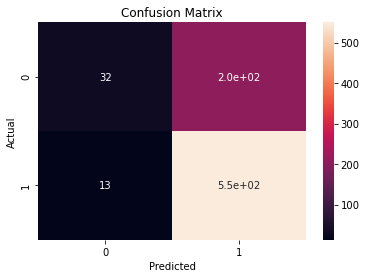

In [37]:
#In sample
acc_in = list(confusion_mat(y_pred_train, y_train))

We can see that the model performs well, although has quite a few false positives, this is likely due to the sparsity of the zero outcome in the datasets.

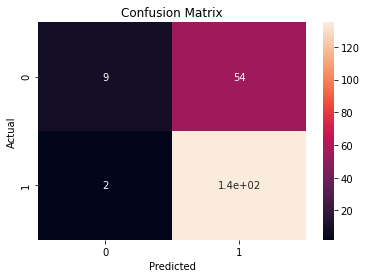

In [38]:
# Out sample
acc_out = list(confusion_mat(y_pred_test, y_test))

We can see the out of sample confusion matrix above suffers from the same issues.

Let us consider the following ways to measure the accuracy of predictions:
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$


$$
\text{Specificity} = \frac{\text{True Negatives}}{\text{True Negatives} + \text{False Positives}}
$$


$$
\text{Accuracy} = \frac{\text{True Positives}+\text{True Negatives} }{\text{Total}}
$$


$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$


$$
\text{F-score} = \frac{2 \cdot \text{True Positives}}{2\cdot \text{True Positives} + \text{False Positives} + \text{False negatives}}
$$

Presenting these for the above model:

In [39]:
# Present data
acc_in = ["In sample"] + acc_in
acc_out = ["Out of sample"] + acc_out
table = [acc_in, acc_out]
headers=["In/out", "Specificity", "Accuracy", "Precision", "Recall", "F-Score"]
print(tabulate(table, headers))

In/out           Specificity    Accuracy    Precision    Recall    F-Score
-------------  -------------  ----------  -----------  --------  ---------
In sample             0.7275    0.711111     0.976909  0.728477   0.834598
Out of sample         0.72      0.818182     0.985401  0.714286   0.828221


Observing the above table we see that out model performs well, especially its precision.

### Task 2.3.1

Firstly to set my data types and ensure that i have an augmented matrix $X$.

In [40]:
# Import training and test data
train_data = np.genfromtxt('classification_train.csv', delimiter=',')
test_data = np.genfromtxt('classification_test.csv', delimiter=',')
np.random.seed(190)
X_train = train_data[:,:-1]# Transpose for use with logistic regression
y_train = train_data[:,-1]
X_test = test_data[:,:-1]# Transpose for use with logistic regression
y_test = test_data[:,-1]







#X_train = X_train.to_numpy()
ones = np.ones(X_train.shape[0])
X_train = np.hstack((X_train, ones[:, None]))
X_train[:, :-1] = standardise(X_train[:, :-1])
#y_train = y_train.to_numpy()
y_train[y_train == 0] = -1
y_train = y_train.astype(float)

#X_test = X_test.to_numpy()
ones = np.ones(X_test.shape[0])
X_test = np.hstack((X_test, ones[:, None]))
X_test[:, :-1] = standardise(X_test[:, :-1])
#y_test = y_test.to_numpy()
y_test[y_test == 0] = -1
y_test = y_test.astype(float)

Let us define the function `rbf()` below which is the Gaussian radial basis function:
$$
k(x,y) = e^{- \frac{\lVert x- y \rVert ^2}{\sigma}}
$$
    

In [41]:
def rbf(x, w, sigma=10**8):
    '''
    Radial Basis Kernel function

    Parameters
    ----------
    x : (N,)
        Vector input.
    w : (N,)
        Vector input.
    sigma : variance paramter, optional
            The default is 10**8.

    Returns
    -------
    ans : (N,)
        Output of Radial basis function.

    '''
    ans = np.exp(-(np.linalg.norm(x-w)**2) / sigma)
    return ans

This has been implimented into the functions from the coding task to replace the dot product. Note though in my implimentation of the RBF, I consider the non-augmented data matrix, that is without ones, and therefore consider an additional parameter $b$, to represent the intercept. When calculating the gradient, which is used in gradient descent we now need to calculate the gradient of:

$$
\mathcal L (\boldsymbol w) = \frac{1}{2} \| \boldsymbol w \|^2 + \frac{\lambda}{n} \sum_{i=1}^n \max \bigg( 0, 1-y_i (k(\boldsymbol w, x_i) + b) \bigg) \, .
$$

This is :

$$
 \frac{\partial \mathcal L}{\partial \boldsymbol w} = \boldsymbol w + \frac{2 \lambda (x_i - \boldsymbol w )y_i}{n \sigma}  k(\boldsymbol w, x)
$$

We then move in this direction at a rate of the given learning rate, that is: updating the weights according to
$
\boldsymbol w = \boldsymbol w - \alpha \frac{\partial \mathcal L}{\partial \boldsymbol w}
$.

This is all implimented by amending the code provided in the notebook. It is done such that the linear SVM still works the same if the argument `KBF`, which has been added, is false.

In [42]:
def compute_cost(W, X, y, sigma, b, regul_strength=1e5, RBF=False):
  n = X.shape[0]
  if RBF:
      distances = 1 - y * (rbf(X, W, sigma)+b) ####
  else:
      distances = 1 - y * (np.dot(X, W))
  distances[distances < 0] = 0  # equivalent to max(0, distance)
  hinge = regul_strength * (np.sum(distances) / n)  

  # calculate cost
  cost = 1 / 2 * np.dot(W, W) + hinge
  return cost


# calculate gradient of cost
def calculate_cost_gradient(W, X_batch, y_batch, sigma, b, regul_strength=1e5, RBF=False):
  # if only one example is passed
  if type(y_batch) == np.float64:
      y_batch = np.asarray([y_batch])
      X_batch = np.asarray([X_batch])  # gives multidimensional array
  if RBF:
      distance = 1 - (y_batch * rbf(X_batch, W, sigma) + b)
  else:
      distance = 1 - (y_batch * np.dot(X_batch, W))
  dw = np.zeros(len(W))

  for ind, d in enumerate(distance):
      if max(0, d)==0:
          di = W
      else:
          if RBF:
              di = W - ((2*regul_strength*y_batch[ind]*(X_batch[ind]-W)*rbf(X_batch[ind], W, sigma))/sigma)
          else:
              di = W - (regul_strength * y_batch[ind] * X_batch[ind])
      dw += di

  dw = dw/len(y_batch)  # average
  return dw



def sgd(X, y, sigma, b, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=1e5, print_outcome=False, RBF=False):
  # initialise zero weights
  weights = np.zeros(X.shape[1])
  nth = 0
  # initialise starting cost as infinity
  prev_cost = np.inf
  
  # stochastic gradient descent
  for iteration in range(1, max_iterations):
      # shuffle to prevent repeating update cycles
      np.random.shuffle([X, y])
      for ind, x in enumerate(X):
          ascent = calculate_cost_gradient(weights, x, y[ind], sigma, b, regul_strength, RBF) 
          weights = weights - (learning_rate * ascent)

      # convergence check on 2^n'th iteration
      if iteration==2**nth or iteration==max_iterations-1:
          # compute cost
          cost = compute_cost(weights, X, y, sigma, b, regul_strength, RBF)
          if print_outcome:
            print("Iteration is: {}, Cost is: {}".format(iteration, cost))
          # stop criterion
          if abs(prev_cost - cost) < stop_criterion * prev_cost:
              return weights
          
          prev_cost = cost
          nth += 1
  
  return weights

def score(W, X, y, sigma, b=-0.0001, RBF=False):
  y_preds = np.array([])
  for i in range(X.shape[0]):
    if RBF:
        sgn = rbf(X[i], W, sigma) + b
    else:
        sgn = np.dot(X[i], W)
    y_pred = np.sign(sgn)
    y_preds = np.append(y_preds, y_pred)
  #print(y_preds)
  return np.float(sum(y_preds==y)) / float(len(y)) 

Throughout this task we are mainly considering the F-score of our predictions and hence i define a function to calcualte this, recalling that a '0' result is now represented as a -1 in our outputs. This is done in the function `F1()`

In [43]:
def pred(W, X, sigma, b=-0.0001, RBF=False):
  y_preds = np.array([])
  for i in range(X.shape[0]):
    if RBF:
        sgn = rbf(X[i], W, sigma) + b
    else:
        sgn = np.dot(X[i], W)
    y_pred = np.sign(sgn) 
    y_preds = np.append(y_preds, y_pred)
  return y_preds

#y_pred = pred(W, X_train, sigma=10**10, b=-0.0001, RBF=False)



def F1(y_actu, y_pred):
    '''
    Computes the F1 score.

    Parameters
    ----------
    y_actu : (N,)
        Actual Outputs.
    y_pred : (N,)
        preducted outputs.


    Returns
    -------
    F1 : float
        F1 score.

    '''
    y_actu, y_pred = list(y_actu), list(y_pred)
    FP = 0
    TN = 0
    TP = 0
    FN = 0
    l = len(y_actu)
    for i in range(l):
        if y_actu[i] == -1:
            if y_pred[i] == 1:
                FP += 1
            else:
                TN += 1
        if y_actu[i] == 1:
            if y_pred[i] == 1:
                TP += 1
            else:
                FN += 1
    F1 = 2 * TP / (2*TP +FP+FN)
    return F1

def score2(W, X, y, sigma, b=-0.0001, RBF=False):
    y_pred = pred(W, X, sigma, b, RBF)
    f1 = F1(y, y_pred)
    return f1

To give a hard margin for the linear SVM we consider what would happen if we allow the penality, that is the regularisation strength, to tend to infinity. We can see that this would essentially cause the soft margin SVM to become hard margined. This is what I do here, I pick a regualation parameter that is large, I have picked $10^{6}$. Below I have implimented this:

In [44]:
W = sgd(X_train, y_train,sigma=None, b=None, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-3, regul_strength=1e6, print_outcome=True, RBF=False)
print("(Linear) Accuracy on train set: {}".format(score(W, X_train, y_train, sigma=None,b=None, RBF=False)))
print("(Linear) Accuracy on test set: {}".format(score(W, X_test, y_test, sigma=None, b=None, RBF=False)))

linear = [score2(W, X_train, y_train, sigma=None, b=None, RBF=False), score2(W, X_test, y_test, sigma=None, b=None, RBF=False) ]
print("(Linear) F-score on train set: {}".format(linear[0]))
print("(Linear) F-score on test set: {}".format(linear[1]))


Iteration is: 1, Cost is: 2221958081.939037
Iteration is: 2, Cost is: 1828460560.913441
Iteration is: 4, Cost is: 1861256362.6931775
Iteration is: 8, Cost is: 1889119639.4770477
Iteration is: 16, Cost is: 2101093820.773332
Iteration is: 32, Cost is: 1988457335.4365926
Iteration is: 64, Cost is: 2192640357.3838296
Iteration is: 128, Cost is: 1929353519.6920037
Iteration is: 256, Cost is: 1730673784.1421652
Iteration is: 512, Cost is: 2301287944.992327
Iteration is: 1024, Cost is: 2025020351.1454577
Iteration is: 1999, Cost is: 1739332058.0386016
(Linear) Accuracy on train set: 0.685
(Linear) Accuracy on test set: 0.72
(Linear) F-score on train set: 0.78125
(Linear) F-score on test set: 0.7985611510791367


We can see that, since the cost is being printed and doesnt seem to decrease across the iterations (it only fluctuates up and down a little), the function is strugling to minimise this, this is due to the large regulation strength forcing the hard margin.

I now apply the same philosophy to the system with the RBF to force it to to be a hard margin.

Below I intiaily vary $\sigma \in [1, 300]$ while keeping $b = -10^{-5}$ to get a rough idea of what happens.

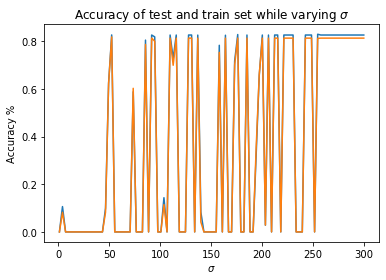

Optimal sigma for b = -0.00001 is: 52.343434343434346
Out of sample F-score: 0.8181818181818182
In sample F-score: 0.8265078183172003


In [45]:
sigmas = np.linspace(1, 300, 100)
train =[]
test =[]
count=0
b=-10**-5
for sigma in sigmas:
    W = sgd(X_train[:, :-1], y_train, sigma=sigma,b=b, max_iterations=1000, stop_criterion=0.01, learning_rate=1e-3, regul_strength=1e6, print_outcome=False, RBF=True)
    train += [score2(W, X_train[:, :-1], y_train, sigma, b=b, RBF=True)]
    test += [score2(W, X_test[:, :-1], y_test, sigma, b=b, RBF=True)]
    
plt.plot(sigmas, train)
plt.plot(sigmas, test)
plt.title(r"Accuracy of test and train set while varying $\sigma$")
plt.xlabel(r"$\sigma$")
plt.ylabel("Accuracy %")
plt.show()


index = np.argmax(test)
print('Optimal sigma for b = -0.00001 is:', sigmas[index])
print('Out of sample F-score:', test[index])
print('In sample F-score:', train[index])

As we can see from the plot there are multiple maximums across this range of $\sigma$, and also these maximums seem to require a very finely tuned $\sigma$, that is the maximums do not last long while varing $\sigma$. I present the In and out of sample F-scores below:

In [46]:
# Present data
table = [["Linear SVM", linear[0], linear[1]], ["RBF SVM", train[index], test[index]]]
headers=["Method", "In sample F-score", "Out of sample F-score"]
print(tabulate(table, headers))

Method        In sample F-score    Out of sample F-score
----------  -------------------  -----------------------
Linear SVM             0.78125                  0.798561
RBF SVM                0.826508                 0.818182


As we see the RBF SVM provides a higher F-score than the the linear SVM, this perhaps implies that it is not possible to represent this data as a hard margined liear SVM modeled.

I perform a 5 fold cross validation grid search on the $\sigma$'s and the $b$'s. 

In [47]:
# NB. This may take a couple minutes
# Initialise hyperparameters
nsigma = 50
nb = 8
n  = nsigma*nb
sigmass = np.linspace(50, 110, nsigma+1)[1:]
bs = -np.linspace(20*10**-6, 5*10**-8, nb)
params = np.array(np.meshgrid(sigmass, bs)).T.reshape(-1,2)

# Initialise  array to contain the MSE of the hyperparameters for each fold
acc = np.empty((5,n))
train_data[:,:-1] = standardise(train_data[:,:-1])
folds = cross_val_split(train_data, 5)




# 5 fold cross validation grid 
for index in range(5):
    cv_X_train, cv_y_train, cv_X_val, cv_y_val = cross_val_train_test(folds, index)
    cv_X_train, cv_X_val = cv_X_train, cv_X_val
    print("Computing fold", index+1)
    for i in range(n):
        sigma = params[i, 0]
        b = params[i, 1]
        W = sgd(cv_X_train, cv_y_train, sigma, b, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-3, regul_strength=1e6, print_outcome=False, RBF=True)
        val_score = score2(W, cv_X_val, cv_y_val, sigma, b, RBF=True)
        acc[index, i] = val_score 
   
# Index of the parameters which minimses the MSE of each fold  
index = np.argmax(acc, axis =1) 
paramshat = params[index, :]
val_acc = acc[np.arange(5), index]
in_acc = np.empty(5)
out_acc = np.empty(5)
for i in range(5):
    sigma = paramshat[i, 0]
    b = paramshat[i, 1]
    W = sgd(X_train[:, :-1], y_train, sigma, b, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-3, regul_strength=1e6, print_outcome=False, RBF=True)
    f1 = score2(W, X_test[:, :-1], y_test, sigma, b, RBF=True)
    out_acc[i] = f1
    f1 = score2(W, X_train[:, :-1], y_train, sigma, b, RBF=True)
    in_acc[i] = f1




# Present data
table = np.column_stack((np.arange(1, 6), paramshat[:,0], paramshat[:,1], val_acc, in_acc, out_acc))
headers=["Val Fold #", "Sigma hat", "b hat", "Val set F-score", "In sample F-score", "Out sample F-score"]
print(tabulate(table, headers))

Computing fold 1
Computing fold 2
Computing fold 3
Computing fold 4
Computing fold 5
  Val Fold #    Sigma hat     b hat    Val set F-score    In sample F-score    Out sample F-score
------------  -----------  --------  -----------------  -------------------  --------------------
           1         58.4  -5e-08             0.831461             0                     0
           2         89.6  -2.9e-06           0.856115             0.826471              0.813056
           3         66.8  -8.6e-06           0.856061             0.779097              0.756579
           4         62    -5e-08             0.796992             0                     0
           5         59.6  -5e-08             0.833948             0                     0


It is interesting to note that some paramters that perform highly against the validation set perform very poorly In and out of sample (having a F-score of of 0), this is likely due to the fact the  maximums are very sensitive on the data. To alleviate (as  have done with all other cross validations) this I find the paramters that minimise the average F-score. It should also be noted that this is not a rigorous grid search which should be done if computation time wasnt such an issue. I find the parameters that maximise the average F-score below: 

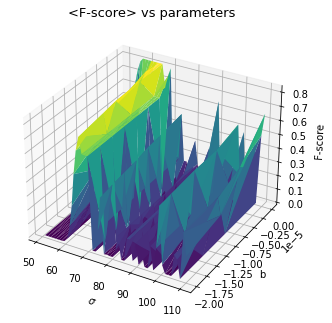

  Sigma hat     b hat    CV <F-score>    In sample F-score    Out sample F-score
-----------  --------  --------------  -------------------  --------------------
       66.8  -8.6e-06        0.828301             0.779097              0.756579


In [48]:
 # Avg mse
acc = np.mean(acc, axis=0)
# Plot of hyperparameters against accuracy 
x = params[:,0]
y = params[:,1]
z = acc
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(x, y, z, cmap=cm.viridis)
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel("b")
ax.set_zlabel("F-score")
ax.set_title("<F-score> vs parameters", fontsize=13)
plt. show()

# Find hyperparameters that maximise average accuracy 
index = np.argmax(acc) 
paramshat = params[index,:]

sigma = paramshat[0]
b = paramshat[1]
W = sgd(X_train[:, :-1], y_train, sigma=sigma,b=b, max_iterations=1000, stop_criterion=0.01, learning_rate=1e-3, regul_strength=1e6, print_outcome=False, RBF=True)
f1 = score2(W, X_test[:, :-1], y_test, sigma, b, RBF=True)
out_acc = f1
f1 = score2(W, X_train[:, :-1], y_train, sigma, b, RBF=True)
in_acc = f1

# Display as table
table = np.array([paramshat[0], paramshat[1], acc[index], in_acc, out_acc])
headers=["Sigma hat", "b hat", "CV <F-score>", "In sample F-score", "Out sample F-score"]
table = table[None, :]
print(tabulate(table, headers))

We can see, looking at the plot that various peaks are are found across the grid.

We can see that the optimal found by cross validation is infact worse off than the optimal we naively chose before, this is likely due to a poor choice of grid- as you can see it scans across several peaks. Idealy we would do a finer search, It is also worse off than the linear SVM, although perhaps it  would generalise better to new data since it has been found through cross validation.

### Task 2.3.2

I below define a function `ROC()` that returns the True positive rate and the False positive rate for use with ROC curves.

In [49]:
def ROC(y_actu, y_pred):
    '''
    Computes the F1 score.

    Parameters
    ----------
    y_actu : (N,)
        Actual Outputs.
    y_pred : (N,)
        preducted outputs.


    Returns
    -------
    TPR : list
        TPR.
    FPR : list
        FPR

    '''
    y_actu, y_pred = list(y_actu), list(y_pred)
    FP = 0
    TN = 0
    TP = 0
    FN = 0
    l = len(y_actu)
    for i in range(l):
        if y_actu[i] == -1:
            if y_pred[i] == 1:
                FP += 1
            else:
                TN += 1
        if y_actu[i] == 1:
            if y_pred[i] == 1:
                TP += 1
            else:
                FN += 1
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    return TPR, FPR

I first perform this on a very fine range of $\sigma$'s around the optimal we found previously through cross validation.

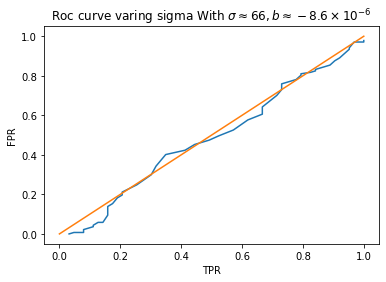

In [50]:
n=50
sigmas = np.linspace(66.7917,66.79176,n)
tprates = np.empty(n)
fprates = np.empty(n)


for i in range(n):
    W = sgd(X_train[:,:-1], y_train, sigmas[i], b, 2000, 0.01, 1e-3, 1e6, print_outcome=False, RBF=True)
    y_pred = pred(W, X_test[:,:-1], sigma, b=b, RBF=True)
    TPR, FPR = ROC(y_test, y_pred)
    tprates[i] = TPR
    fprates[i] = FPR
    

x = np.linspace(0,1,100)
plt.plot(fprates,tprates)
plt.title(r"Roc curve varing sigma With $\sigma \approx 66, b \approx -8.6 \times 10^{-6}$")
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.plot(x,x)
plt.show()

As we can see this ROC curve provides negligble increase on simply chosing randomly. This is perhaps, as previously mentioned due to a coarse grid search and the fact that the maximums are sharp and appear to be very sensitive to parameters. I do another ROC curve for the naively chosen optimal paramters we did at the very start.

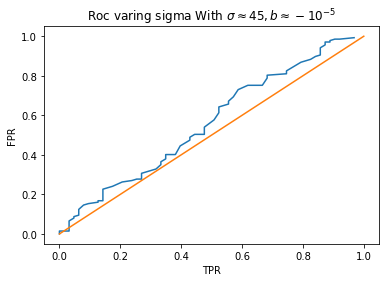

In [51]:
n=100
b = -10**-5
sigma = 50
sigmas = np.linspace(sigma-10,sigma+3,n)
tprates = np.empty(n)
fprates = np.empty(n)


for i in range(n):
    W = sgd(X_train[:,:-1], y_train, sigmas[i], b, 2000, 0.01, 1e-3, 1e6, print_outcome=False, RBF=True)
    y_pred = pred(W, X_test[:,:-1], sigma, b=b, RBF=True)
    TPR, FPR = ROC(y_test, y_pred)
    tprates[i] = TPR
    fprates[i] = FPR
    

x = np.linspace(0,1,100)
plt.plot(fprates,tprates)
plt.title(r"Roc varing sigma With $\sigma \approx 45, b \approx -10^{-5}$")
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.plot(x,x)
plt.show()

We can see here that we have a much better ROC curve than before, that is it is noticeably better than a random choice. And so perhaps models our data fairly well.